In [1]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(".."), "code"))

import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils import *


%matplotlib inline
pd.set_option("display.max_colwidth", 200)

# Lecture 8: Hyperparameter Optimization and Optimization Bias

UBC 2023-24

Instructor: Varada Kolhatkar and Andrew Roth

### (iClicker) Exercise 7.2 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) Increasing logistic regression's `C` hyperparameter increases model complexity.
- (B) For logistic regression the raw output score can be used to calculate the probability score for a given prediction. 
- (C) For linear classifier trained on $d$ features, the decision boundary is a $d-1$-dimensional hyperparlane.  
- (D) A linear model is likely to be uncertain about the data points close to the decision boundary. 

### Learning outcomes 

From this lecture, you will be able to 

- Explain the need for hyperparameter optimization  
- Carry out hyperparameter optimization using `sklearn`'s `GridSearchCV` and `RandomizedSearchCV` 
- Explain different hyperparameters of `GridSearchCV`
- Explain the importance of selecting a good range for the values. 
- Explain optimization bias
- Identify and reason when to trust and not trust reported accuracies 

### Motivation

- Remember that the fundamental goal of supervised machine learning is to generalize beyond what we see in the training examples. 
- We have been using data splitting and cross-validation to provide a framework to approximate generalization error.  
- With this framework, we can improve the model's generalization performance by tuning model hyperparameters using cross-validation on the training set. 

### Hyperparameters: the problem

- In order to improve the generalization performance, finding the best values for the important hyperparameters of a model is necessary for almost all models and datasets. 

- Picking good hyperparameters is important because if we don't do it, we might end up with an underfit or overfit model. 

### Some ways to pick hyperparameters:

- Manual or expert knowledge or heuristics based optimization 

- Data-driven or automated optimization

### Manual hyperparameter optimization

- Advantage: we may have some intuition about what might work.
  - E.g. if I'm massively overfitting, try decreasing `max_depth` or `C`.

- Disadvantages
    - It takes a lot of work
    - Not reproducible
    - In very complicated cases, our intuition might be worse than a data-driven approach

### Automated hyperparameter optimization 

- Formulate the hyperparamter optimization as a one big search problem. 

- Often we have many hyperparameters of different types: Categorical, integer, and continuous.

- Often, the search space is quite big and systematic search for optimal values is infeasible. 

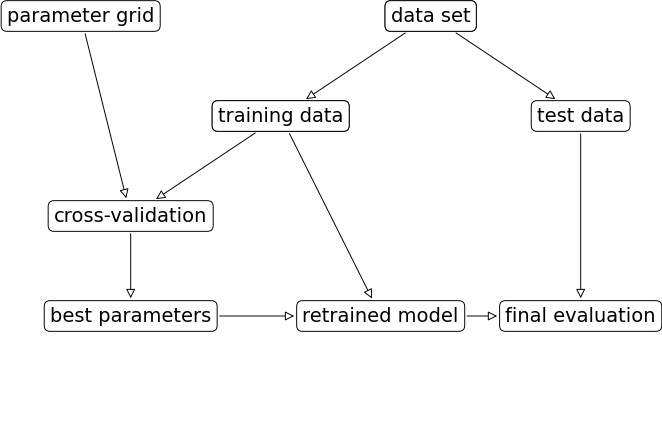

In [2]:
mglearn.plots.plot_grid_search_overview()

In [3]:
spotify_df = pd.read_csv("../data/spotify.csv", index_col=0)
X_spotify = spotify_df.drop(columns=["target", "artist"])
y_spotify = spotify_df["target"]
X_spotify.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,Mask Off
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,Redbone
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,Xanny Family
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,Master Of None
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,Parallel Lines


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_spotify, y_spotify, test_size=0.2, random_state=123
)

In [5]:
numeric_feats = [
    'acousticness', 'danceability', 'energy',
    'instrumentalness', 'liveness', 'loudness',
    'speechiness', 'tempo', 'valence'
]
categorical_feats = ['time_signature', 'key']
passthrough_feats = ['mode']
text_feat = "song_title"

In [6]:
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_feats), 
    (OneHotEncoder(handle_unknown = "ignore"), categorical_feats), 
    ("passthrough", passthrough_feats), 
    (CountVectorizer(max_features=100, stop_words="english"), text_feat)
)

svc_pipe = make_pipeline(preprocessor, SVC)

In [7]:
best_score = 0
param_grid = {"max_depth": np.arange(1, 20, 2)}
results_dict = {"max_depth": [], "mean_cv_score": []}

for depth in param_grid["max_depth"]:  # for each combination of parameters, train an SVC
    dt_pipe = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth=depth))
    scores = cross_val_score(dt_pipe, X_train, y_train)  # perform cross-validation
    mean_score = np.mean(scores)  # compute mean cross-validation accuracy
    if mean_score > best_score:  # if we got a better score, store the score and parameters
        best_score = mean_score
        best_params = {"max_depth": depth}
    results_dict["max_depth"].append(depth)
    results_dict["mean_cv_score"].append(mean_score)

In [8]:
best_params

{'max_depth': 5}

In [9]:
best_score

0.729702132569275

### Tuning SVC

In [10]:
pipe_svm = make_pipeline(preprocessor, SVC())  # We need scaling for SVM RBF
scores = cross_validate(pipe_svm, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       0.084608
score_time     0.020084
test_score     0.734011
train_score    0.828891
dtype: float64

Now let's try exhaustive hyperparameter search using for loops. 

This is what we have been doing for this:

```
for gamma in [0.01, 1, 10, 100]: # for some values of gamma
    for C in [0.01, 1, 10, 100]: # for some values of C
        for fold in folds:
            fit in training portion with the given C
            score on validation portion
        compute average score
        
pick hyperparameter values which yield with best average score
```

In [11]:
best_score = 0
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1, 10, 100],
}
results_dict = {"C": [], "gamma": [], "mean_cv_score": []}

In [12]:
for gamma in param_grid["gamma"]:
    for C in param_grid["C"]:  # for each combination of parameters, train an SVC
        pipe_svm = make_pipeline(preprocessor, SVC(C=C, gamma=gamma))
        scores = cross_val_score(pipe_svm, X_train, y_train)  # perform cross-validation
        mean_score = np.mean(scores)  # compute mean cross-validation accuracy
        if mean_score > best_score:  # if we got a better score, store the score and parameters
            best_score = mean_score
            best_parameters = {"C": C, "gamma": gamma}
        results_dict["C"].append(C)
        results_dict["gamma"].append(gamma)
        results_dict["mean_cv_score"].append(mean_score)

In [13]:
best_parameters

{'C': 1, 'gamma': 0.1}

In [14]:
best_score

0.7352614272253524

In [15]:
df = pd.DataFrame(results_dict)
df.sort_values(by="mean_cv_score", ascending=False).head(10)

,C,gamma,mean_cv_score
15,1.0,0.100,0.735261
16,10.0,0.100,0.722249
11,100.0,0.010,0.716657
10,10.0,0.010,0.716655
5,100.0,0.001,0.705511
14,0.1,0.100,0.701173
9,1.0,0.010,0.691877
17,100.0,0.100,0.677601
4,10.0,0.001,0.673277
8,0.1,0.010,0.652828


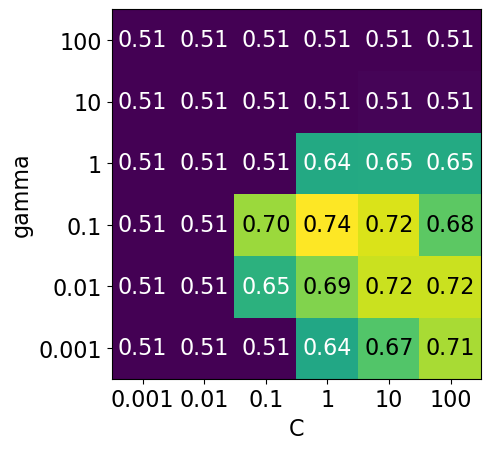

In [16]:
scores = np.array(df.mean_cv_score).reshape(6, 6)
mglearn.tools.heatmap(
    scores,
    xlabel="C",
    xticklabels=param_grid["C"],
    ylabel="gamma",
    yticklabels=param_grid["gamma"],
    cmap="viridis",
)

- We have 6 possible values for `C` and 6 possible values for `gamma`. 

- In 5-fold cross-validation, for each combination of parameter values, five accuracies are computed.

- So to evaluate the accuracy of the SVM using 6 values of `C` and 6 values of `gamma` using five-fold cross-validation, we need to train xxxx models! 

Once we have optimized hyperparameters, we retrain a model on the full training set with these optimized hyperparameters. 

In [17]:
svc_pipe = make_pipeline(preprocessor, SVC(C=best_parameters["C"], gamma=best_parameters["gamma"]))
svc_pipe.fit(X_train, y_train)
svc_pipe.score(X_test, y_test)

0.75

This process is so common that there are some standard methods in `scikit-learn` where we can carry out all of this in a more compact way. 

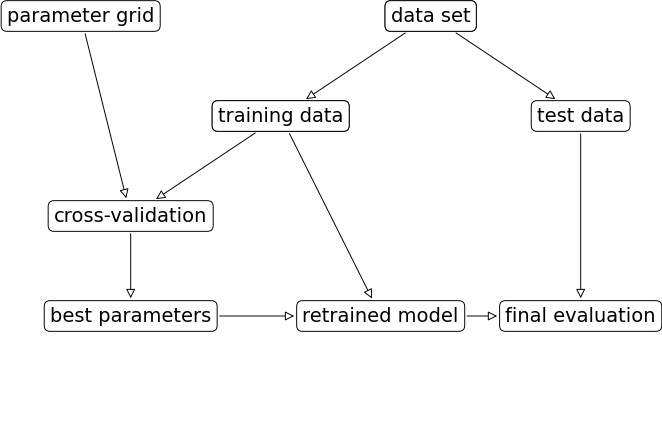

In [18]:
mglearn.plots.plot_grid_search_overview()

In this lecture we are going to talk about two such most commonly used automated optimizations methods from `scikit-learn`. 

- Exhaustive grid search: [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- Randomized search: [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

The "CV" stands for cross-validation; these methods have built-in cross-validation.

## Exhaustive grid search: [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

- For `GridSearchCV` we need
    - an instantiated model or a pipeline
    - a parameter grid: A user specifies a set of values for each hyperparameter. 
    - other optional arguments 

The method considers product of the sets and evaluates each combination one by one.    

In [19]:
from sklearn.model_selection import GridSearchCV

pipe_svm = make_pipeline(preprocessor, SVC())

param_grid = {
    "columntransformer__countvectorizer__max_features": [100, 200, 400, 800, 1000, 2000],
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}

# Create a grid search object
grid_search = GridSearchCV(pipe_svm, param_grid, cv=5, n_jobs=-1, return_train_score=True)

In [20]:
from sklearn import set_config

set_config(display="diagram")

The `GridSearchCV` object above behaves like a classifier. We can call `fit`, `predict` or `score` on it. 

In [21]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['acousticness',
                                                                          'danceability',
                                                                          'energy',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'tempo',
                                                                          'valence']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['time_signature',
                                                                          'key']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['mode']),
                                                                        ('countvectorizer',
                                                                         CountVectorizer(max_features=100,
                                                                                         stop_words='english'),
                                                                         'song_title')])),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'columntransformer__countvectorizer__max_features': [100,
                                                                              200,
                                                                              400,
                                                                              800,
                                                                              1000,
                                                                              2000],
                         'svc__C': [0.001, 0.01, 0.1, 1.0, 10, 100],
                         'svc__gamma': [0.001, 0.01, 0.1, 1.0, 10, 100]},
             return_train_score=True)

- It is often helpful to visualize results of all cross-validation experiments. 
- You can access this information using `cv_results_` attribute of a fitted `GridSearchCV` object.  

In [22]:
results = pd.DataFrame(grid_search.cv_results_)
results.T

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
mean_fit_time,0.3129,0.317402,0.318038,0.316564,0.327592,0.385581,0.310575,0.332467,0.34058,0.322459,...,0.998885,0.897492,0.84445,0.692248,0.46924,0.556294,0.448591,0.462728,0.451487,0.470856
std_fit_time,0.014065,0.002811,0.014726,0.002606,0.007457,0.024828,0.001589,0.026281,0.043084,0.001987,...,0.076945,0.060188,0.030602,0.02552,0.038753,0.065264,0.004724,0.0603,0.006248,0.050632
mean_score_time,0.090046,0.082929,0.082356,0.086134,0.087315,0.102047,0.082758,0.099931,0.090909,0.088123,...,0.176486,0.191313,0.165767,0.142972,0.088883,0.072625,0.085139,0.103724,0.100183,0.097011
std_score_time,0.008807,0.003897,0.002679,0.001338,0.002924,0.002685,0.002746,0.030257,0.011999,0.002463,...,0.007079,0.005768,0.023229,0.003007,0.012636,0.003285,0.002746,0.005543,0.001469,0.026408
param_columntransformer__countvectorizer__max_features,100,100,100,100,100,100,100,100,100,100,...,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
param_svc__C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,10,10,10,10,100,100,100,100,100,100
param_svc__gamma,0.001,0.01,0.1,1.0,10,100,0.001,0.01,0.1,1.0,...,0.1,1.0,10,100,0.001,0.01,0.1,1.0,10,100
params,"{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 0.01}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 1.0}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 10}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 100}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.01, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.01, 'svc__gamma': 0.01}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.01, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.01, 'svc__gamma': 1.0}",...,"{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 10, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 10, 'svc__gamma': 1.0}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 10, 'svc__gamma': 10}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 10, 'svc__gamma': 100}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 0.01}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 1.0}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 10}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 100}"
split0_test_score,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,...,0.733746,0.616099,0.50774,0.504644,0.718266,0.718266,0.724458,0.616099,0.50774,0.504644
split1_test_score,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,...,0.77709,0.625387,0.510836,0.510836,0.724458,0.739938,0.764706,0.625387,0.510836,0.510836


In [23]:
pd.DataFrame(grid_search.cv_results_)[
    [
        "mean_test_score",
        "param_columntransformer__countvectorizer__max_features", 
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,5,7,8,9,10,...,121,121,121,121,121,121,121,121,121,121
mean_test_score,0.739598,0.738977,0.736498,0.735879,0.735261,0.735261,0.727829,0.727198,0.726583,0.726573,...,0.50775,0.50775,0.50775,0.50775,0.50775,0.50775,0.50775,0.50775,0.50775,0.50775
param_columntransformer__countvectorizer__max_features,1000,2000,400,800,200,100,800,1000,2000,400,...,1000,1000,1000,400,400,400,400,400,1000,100
param_svc__gamma,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.01,0.001,0.001,0.01,0.1,1.0,10,100,0.001
param_svc__C,1.0,1.0,1.0,1.0,1.0,1.0,10,10,10,10,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
mean_fit_time,0.371864,0.747294,0.344238,0.351213,0.324994,0.293022,0.459471,0.51741,0.998885,0.48337,...,0.453231,0.398281,0.412341,0.369529,0.401357,0.395857,0.381007,0.388232,0.462429,0.3129


- Other than searching for best hyperparameter values, `GridSearchCV` also fits a new model on the whole training set with the parameters that yielded the best results. 
- So we can conveniently call `score` on the test set with a fitted `GridSearchCV` object. 

In [24]:
# Get the test scores 
grid_search.score(X_test, y_test)

0.7574257425742574

### Problems with exhaustive grid search 

- Required number of models to evaluate grows exponentially with the dimensionally of the configuration space. 

- Example: Suppose you have
    - 5 hyperparameters 
    
    - 10 different values for each hyperparameter

    - You'll be evaluating $10^5=100,000$ models! That is you'll be calling `cross_validate` 100,000 times!

    - Exhaustive search may become infeasible fairly quickly. 

- Other options? 

### Randomized hyperparameter search

- Randomized hyperparameter optimization 
    - [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
- Samples configurations at random until certain budget (e.g., time) is exhausted 

In [25]:
from sklearn.model_selection import RandomizedSearchCV


param_grid = {
    "columntransformer__countvectorizer__max_features": [100, 200, 400, 800, 1000, 2000],
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": np.linspace(2, 3, 6),
}

print("Grid size: %d" % (np.prod(list(map(len, param_grid.values())))))
param_grid

Grid size: 216


{'columntransformer__countvectorizer__max_features': [100,
  200,
  400,
  800,
  1000,
  2000],
 'svc__gamma': [0.001, 0.01, 0.1, 1.0, 10, 100],
 'svc__C': array([2. , 2.2, 2.4, 2.6, 2.8, 3. ])}

In [26]:
# Create a random search object
random_search = RandomizedSearchCV(svc_pipe, param_distributions=param_grid, n_jobs=-1, n_iter=20, cv=5, random_state=42)

# Carry out the search
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['acousticness',
                                                                                'danceability',
                                                                                'energy',
                                                                                'instrumentalness',
                                                                                'liveness',
                                                                                'loudness',
                                                                                'speechiness',
                                                                                'tempo',
                                                                                'valence']),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['time_signature',
                                                                                'key']),
                                                                              ('passthrough',
                                                                               'passthrough',
                                                                               ['mode']),
                                                                              ('countvectorizer',
                                                                               CountVectorizer(max_features=100,
                                                                                               stop_words='english'),
                                                                               'song_title')])),
                                             ('svc', SVC(C=1, gamma=0.1))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'columntransformer__countvectorizer__max_features': [100,
                                                                                             200,
                                                                                             400,
                                                                                             800,
                                                                                             1000,
                                                                                             2000],
                                        'svc__C': array([2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
                                        'svc__gamma': [0.001, 0.01, 0.1, 1.0,
                                                       10, 100]},
                   random_state=42)

In [27]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_columntransformer__countvectorizer__max_features", 
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12,13,14,14,16,16,18,18,18
mean_test_score,0.743321,0.741463,0.71172,0.710476,0.706761,0.706759,0.660866,0.659625,0.659006,0.652185,0.646611,0.645992,0.633596,0.628025,0.628025,0.622454,0.622454,0.50899,0.50899,0.50899
param_columntransformer__countvectorizer__max_features,2000,1000,800,2000,200,400,800,200,100,100,100,100,800,1000,1000,2000,2000,1000,2000,1000
param_svc__gamma,0.1,0.1,0.01,0.01,0.01,0.01,0.001,0.001,0.001,0.001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10,10,10
param_svc__C,2.0,3.0,3.0,2.8,3.0,2.0,3.0,3.0,3.0,2.6,2.4,2.2,2.0,2.4,3.0,3.0,2.6,2.2,2.2,2.8
mean_fit_time,0.51042,0.426658,0.32615,0.370865,0.306083,0.306062,0.352345,0.321206,0.316762,0.339304,0.38073,0.379397,0.441245,0.436296,0.46167,0.422954,0.4017,0.488947,0.484224,0.467898


### `n_iter`

- Note the `n_iter`, we didn't need this for `GridSearchCV`.
- Larger `n_iter` will take longer but it'll do more searching.
  - Remember you still need to multiply by number of folds!
- I have set the `random_state` for reproducibility but you don't have to do it.


### Advantages of `RandomizedSearchCV`

- Faster compared to `GridSearchCV`.
- Adding parameters that do not influence the performance does not affect efficiency.
- Works better when some parameters are more important than others. 
- In general, I recommend using `RandomizedSearchCV` rather than `GridSearchCV`.    

### Advantages of `RandomizedSearchCV`

![](../img/randomsearch_bergstra.png)
    
Source: [Bergstra and Bengio, Random Search for Hyper-Parameter Optimization, JMLR 2012](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).

- The yellow on the left shows how your scores are going to change when you vary the unimportant hyperparameter.
- The green on the top shows how your scores are  going to change when you vary the important hyperparameter.
- You don't know in advance which hyperparameters are important for your problem.
- In the left figure, 6 of the 9 searches are useless because they are only varying the unimportant parameter.
- In the right figure, all 9 searches are useful.

### Searching for optimal parameters with successive halving

- Successive halving is an iterative selection process where all candidates (the parameter combinations) are evaluated with a small amount of resources (e.g., small amount of training data) at the first iteration.
- Checkout [successive halving with grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) and [random search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html).


![](../img/successive_halving.png)
    
Source: [scikit learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_iterations.html).

In [28]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import loguniform, randint, uniform

In [29]:
param_dist = {
    "columntransformer__countvectorizer__max_features": randint(100, 2000), 
    "svc__C": uniform(0.1, 1e4),  # loguniform(1e-3, 1e3),
    "svc__gamma": loguniform(1e-5, 1e3),
}

rsh = HalvingRandomSearchCV(
    estimator=pipe_svm, param_distributions=param_dist, factor=2, random_state=123
)

rsh.fit(X_train, y_train)

HalvingRandomSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('standardscaler',
                                                                                  StandardScaler(),
                                                                                  ['acousticness',
                                                                                   'danceability',
                                                                                   'energy',
                                                                                   'instrumentalness',
                                                                                   'liveness',
                                                                                   'loudness',
                                                                                   'speechiness',
                                                                                   'tempo',
                                                                                   'valence']),
                                                                                 ('onehotencoder',
                                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                                  ['time_signature',
                                                                                   'key']),
                                                                                 ('passthrough',
                                                                                  'p...
                      factor=2,
                      param_distributions={'columntransformer__countvectorizer__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f82533413d0>,
                                           'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f82532ebcd0>,
                                           'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f825345c910>},
                      random_state=123)

In [30]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
results

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__countvectorizer__max_features,param_svc__C,param_svc__gamma,params,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,params_str
0,0,20,0.009185,0.000736,0.005209,0.000593,1634,7129.653205,0.026777,"{'columntransformer__countvectorizer__max_features': 1634, 'svc__C': 7129.653205232272, 'svc__gamma': 0.02677733855112973}",...,0.333333,111,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 1634, 'svc__C': 7129.653205232272, 'svc__gamma': 0.02677733855112973}"
1,0,20,0.008664,0.000497,0.004867,0.000476,1222,5513.247691,5.698385,"{'columntransformer__countvectorizer__max_features': 1222, 'svc__C': 5513.247690828913, 'svc__gamma': 5.698384608345687}",...,0.367423,22,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 1222, 'svc__C': 5513.247690828913, 'svc__gamma': 5.698384608345687}"
2,0,20,0.008619,0.000472,0.004798,0.000448,1247,7800.377619,0.019382,"{'columntransformer__countvectorizer__max_features': 1247, 'svc__C': 7800.377619120792, 'svc__gamma': 0.019381838999846482}",...,0.333333,111,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 1247, 'svc__C': 7800.377619120792, 'svc__gamma': 0.019381838999846482}"
3,0,20,0.008512,0.000591,0.004712,0.000479,213,4809.419015,0.013707,"{'columntransformer__countvectorizer__max_features': 213, 'svc__C': 4809.41901484361, 'svc__gamma': 0.013706928443177698}",...,0.359784,144,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 213, 'svc__C': 4809.41901484361, 'svc__gamma': 0.013706928443177698}"
4,0,20,0.008424,0.000609,0.004649,0.000485,1042,6273.270093,0.003919,"{'columntransformer__countvectorizer__max_features': 1042, 'svc__C': 6273.270093376167, 'svc__gamma': 0.003919287722401839}",...,0.406202,97,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 1042, 'svc__C': 6273.270093376167, 'svc__gamma': 0.003919287722401839}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,5,640,0.032643,0.000439,0.008929,0.000193,729,4943.40065,0.092454,"{'columntransformer__countvectorizer__max_features': 729, 'svc__C': 4943.400649628005, 'svc__gamma': 0.09245358900622544}",...,0.051925,10,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 729, 'svc__C': 4943.400649628005, 'svc__gamma': 0.09245358900622544}"
156,5,640,0.031400,0.000288,0.009783,0.001001,1383,2705.246646,0.173979,"{'columntransformer__countvectorizer__max_features': 1383, 'svc__C': 2705.246646103936, 'svc__gamma': 0.1739787032867638}",...,0.046116,9,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 1383, 'svc__C': 2705.246646103936, 'svc__gamma': 0.1739787032867638}"
157,5,640,0.030571,0.000396,0.009017,0.000347,440,5315.613738,0.17973,"{'columntransformer__countvectorizer__max_features': 440, 'svc__C': 5315.613738418384, 'svc__gamma': 0.17973005068132514}",...,0.043509,12,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 440, 'svc__C': 5315.613738418384, 'svc__gamma': 0.17973005068132514}"
158,6,1280,0.102829,0.001758,0.018003,0.000217,729,4943.40065,0.092454,"{'columntransformer__countvectorizer__max_features': 729, 'svc__C': 4943.400649628005, 'svc__gamma': 0.09245358900622544}",...,0.010715,19,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 729, 'svc__C': 4943.400649628005, 'svc__gamma': 0.09245358900622544}"


## (Optional) Fancier methods 
- Both `GridSearchCV` and `RandomizedSearchCV` do each trial independently.
- What if you could learn from your experience, e.g. learn that `max_depth=3` is bad?
  - That could save time because you wouldn't try combinations involving `max_depth=3` in the future.
- We can do this with `scikit-optimize`, which is a completely different package from `scikit-learn`
- It uses a technique called "model-based optimization" and we'll specifically use "Bayesian optimization".
  - In short, it uses machine learning to predict what hyperparameters will be good.
  - Machine learning on machine learning!

### (iClicker) Exercise 8.1 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) If you get best results at the edges of your parameter grid, it might be a good idea to adjust the range of values in your parameter grid.   
- (B) Grid search is guaranteed to find the best hyperparameter values. 
- (C) It is possible to get different hyperparameters in different runs of `RandomizedSearchCV`.

## Break (5 min)

![](../img/eva-coffee.png)

### Overfitting of the validation error 

- Why do we need to evaluate the model on the test set in the end?
- Why not just use cross-validation on the whole dataset? 
- While carrying out hyperparameter optimization, we usually try over many possibilities.  
- If our dataset is small and if your validation set is hit too many times, we suffer from **optimization bias** or **overfitting the validation set**. 

### Optimization bias of parameter learning
- Overfitting of the training error
- An example: 
    - During training, we could search over tons of different decision trees.    
    - So we can get "lucky" and find a tree with low training error by chance.

### Optimization bias of hyper-parameter learning

- Overfitting of the validation error
- An example: 
    - Here, we might optimize the validation error over 1000 values of `max_depth`.
    - One of the 1000 trees might have low validation error by chance.

### (Optional) Example 1: Optimization bias

Consider a multiple-choice (a,b,c,d) "test" with 10 questions:
- If you choose answers randomly, expected grade is 25% (no bias).
- If you fill out two tests randomly and pick the best, expected grade is 33%.
    - Optimization bias of ~8%.
- If you take the best among 10 random tests, expected grade is ~47%.
- If you take the best among 100, expected grade is ~62%.
- If you take the best among 1000, expected grade is ~73%.
- If you take the best among 10000, expected grade is ~82%.
    - You have so many "chances" that you expect to do well.
    
**But on new questions the "random choice" accuracy is still 25%.**

In [31]:
# (Optional) Code attribution: Rodolfo Lourenzutti
number_tests = [1, 2, 10, 100, 1000, 10000]
for ntests in number_tests:
    y = np.zeros(10000)
    for i in range(10000):
        y[i] = np.max(np.random.binomial(10.0, 0.25, ntests))
    print(
        "The expected grade among the best of %d tests is : %0.2f"
        % (ntests, np.mean(y) / 10.0)
    )

The expected grade among the best of 1 tests is : 0.25
The expected grade among the best of 2 tests is : 0.33
The expected grade among the best of 10 tests is : 0.47
The expected grade among the best of 100 tests is : 0.62
The expected grade among the best of 1000 tests is : 0.73
The expected grade among the best of 10000 tests is : 0.82


### (Optional) Example 2: Optimization bias 

- If we instead used a 100-question test then:
    - Expected grade from best over 1 randomly-filled test is 25%.
    - Expected grade from best over 2 randomly-filled test is ~27%.
    - Expected grade from best over 10 randomly-filled test is ~32%.
    - Expected grade from best over 100 randomly-filled test is ~36%.
    - Expected grade from best over 1000 randomly-filled test is ~40%.
    - Expected grade from best over 10000 randomly-filled test is ~43%.

- The optimization bias **grows with the number of things we try**.
    - “Complexity” of the set of models we search over.
- But, optimization bias **shrinks quickly with the number of examples**.
    - But it’s still non-zero and growing if you over-use your validation set!    

In [32]:
# (Optional) Code attribution: Rodolfo Lourenzutti
number_tests = [1, 2, 10, 100, 1000, 10000]
for ntests in number_tests:
    y = np.zeros(10000)
    for i in range(10000):
        y[i] = np.max(np.random.binomial(100.0, 0.25, ntests))
    print(
        "The expected grade among the best of %d tests is : %0.2f"
        % (ntests, np.mean(y) / 100.0)
    )

The expected grade among the best of 1 tests is : 0.25
The expected grade among the best of 2 tests is : 0.27
The expected grade among the best of 10 tests is : 0.32
The expected grade among the best of 100 tests is : 0.36
The expected grade among the best of 1000 tests is : 0.40
The expected grade among the best of 10000 tests is : 0.43


### Optimization bias on the Spotify dataset

In [33]:
spotify_df = pd.read_csv("../data/spotify.csv", index_col=0)
X_spotify = spotify_df.drop(columns=["target", "artist"])
y_spotify = spotify_df["target"]
X_spotify.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,Mask Off
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,Redbone
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,Xanny Family
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,Master Of None
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,Parallel Lines


In [34]:
X_train_tiny, X_test_big, y_train_tiny, y_test_big = train_test_split(
    X_spotify, y_spotify, test_size=0.99, random_state=42
)
X_train_tiny.shape

(20, 14)

In [35]:
X_train_tiny.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title
130,0.055100,0.547,251093,0.643,0.000000,1,0.2670,-8.904,1,0.2270,143.064,4.0,0.1870,My Sub (Pt. 2: The Jackin') - Album Version (Edited)
1687,0.000353,0.420,210240,0.929,0.000747,7,0.1220,-3.899,0,0.1210,127.204,4.0,0.3180,Chop Suey!
871,0.314000,0.430,193427,0.734,0.000286,9,0.0808,-10.043,0,0.1020,133.992,4.0,0.0537,Able to See Me
1123,0.082100,0.725,246653,0.711,0.000000,10,0.0931,-4.544,1,0.0335,93.003,4.0,0.4760,Mi Tesoro (feat. Nicky Jam)
1396,0.286000,0.616,236960,0.387,0.000000,9,0.2770,-6.079,0,0.0335,81.856,4.0,0.4700,All in Vain


In [36]:
pipe = make_pipeline(StandardScaler(), SVC())

In [37]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "svc__gamma": 10.0 ** np.arange(-20, 10),
    "svc__C": 10.0 ** np.arange(-20, 10),
}
print("Grid size: %d" % (np.prod(list(map(len, param_grid.values())))))
param_grid

Grid size: 900


{'svc__gamma': array([1.e-20, 1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13,
        1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
        1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
        1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09]),
 'svc__C': array([1.e-20, 1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13,
        1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
        1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
        1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])}

In [38]:
random_search = RandomizedSearchCV(
    pipe, param_distributions=param_grid, n_jobs=-1, n_iter=900, cv=5, random_state=123
)
random_search.fit(X_train_tiny[numeric_feats], y_train_tiny)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC())]),
                   n_iter=900, n_jobs=-1,
                   param_distributions={'svc__C': array([1.e-20, 1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13,
       1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
       1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09]),
                                        'svc__gamma': array([1.e-20, 1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13,
       1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
       1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])},
                   random_state=123)

In [39]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,1,1,4,4,4,4,4,4,4,...,857,857,893,893,893,893,893,893,893,893
mean_test_score,0.7,0.7,0.7,0.65,0.65,0.65,0.65,0.65,0.65,0.65,...,0.55,0.55,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
param_svc__gamma,0.0,0.0,0.0,100.0,1000.0,10000.0,100000.0,1000000.0,10000000.0,100000000.0,...,0.000001,0.0001,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
param_svc__C,10000000.0,100000000.0,1000000000.0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,100000000.0,10000000.0,10000000.0,100000000.0,1000000.0,10000.0,100000.0,1000.0,100.0,1000000000.0
mean_fit_time,0.007091,0.006921,0.008909,0.006615,0.006458,0.006562,0.006574,0.006631,0.00664,0.006662,...,0.009526,0.006852,0.006553,0.006648,0.007,0.009951,0.00654,0.006372,0.006815,0.006833


- Do we really believe that 0.80 is a good estimate of our test data?
- Do we really believe that `gamma`=0.0 and C=1_000_000_000 are the best hyperparameters?

In [40]:
random_search.score(X_test[numeric_feats], y_test)

0.6262376237623762

### Overfitting of the validation data

The following plot demonstrates what happens during overfitting of the validation data.  
<center>
<img src='../img/optimization-bias.png' width="600">
</center>


[Source](https://amueller.github.io/COMS4995-s20/slides/aml-03-supervised-learning/#20)

### Why do we need a test set? 
- This is why we need a test set.
- The frustrating part is that if our dataset is small then our test set is also small 😔. 
- But we don't have a lot of better alternatives, unfortunately, if we have a small dataset. 

### When test score is much lower than CV score
- What to do if your test score is much lower than your cross-validation score:
    - Try simpler models and use the test set a couple of times; it's not the end of the world.
    - Communicate this clearly when you report the results. 

### Large datasets solve many of these problems
- With infinite amounts of training data, overfitting would not be a problem and you could have your test score = your train score.
    - Overfitting happens because you only see a bit of data and you learn patterns that are overly specific to your sample.
    - If you saw "all" the data, then the notion of "overly specific" would not apply.
- So, more data will make your test score better and robust. 

## ❓❓ Questions for you

Attribution: From Mark Schmidt's notes

Would you trust the model?  

- You have a dataset and you give me 1/10th of it. The dataset given to me is rather small and so I split it into 96% train and 4% validation split. I carry out hyperparameter optimization using a single 4% validation split and report validation accuracy of 0.97. Would it classify the rest of the data with similar accuracy? 

1. Probably 
2. Probably not 

## Final comments and summary

#### Automated hyperparameter optimization

- Advantages 
    - reduce human effort
    - less prone to error and improve reproducibility
    - data-driven approaches may be effective
- Disadvantages
    - may be hard to incorporate intuition
    - be careful about overfitting on the validation set

- The problem of finding the best values for the important hyperparameters is tricky because 
    - You may have a lot of them (e.g. deep learning). 
    - You may have multiple hyperparameters which may interact with each other in unexpected ways.    
- The best settings depend on the specific data/problem.